# 베이스라인 모델

원-핫 인코딩을 한 후, 로지스틱 회귀를 모델로

In [1]:
import pandas as pd 
import numpy as np

In [2]:
train=pd.read_csv('train.csv',index_col='id')#지정한 열이 인덱스
test=pd.read_csv('test.csv',index_col='id')
submission=pd.read_csv('sample_submission.csv',index_col='id')

# 피처 엔지니어링

## 데이터 합치기

In [3]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop('target', axis = 1)
all_data

bin_0  bin_1  bin_2 bin_3 bin_4  nom_0      nom_1    nom_2  \
0           0      0      0     T     Y  Green   Triangle    Snake   
1           0      1      0     T     Y  Green  Trapezoid  Hamster   
2           0      0      0     F     Y   Blue  Trapezoid     Lion   
3           0      1      0     F     Y    Red  Trapezoid    Snake   
4           0      0      0     F     N    Red  Trapezoid     Lion   
...       ...    ...    ...   ...   ...    ...        ...      ...   
499995      0      0      0     F     N  Green     Square     Lion   
499996      1      0      0     F     Y  Green  Trapezoid     Lion   
499997      0      1      1     T     Y  Green  Trapezoid     Lion   
499998      1      0      0     T     Y   Blue       Star  Hamster   
499999      0      0      0     T     Y  Green       Star     Lion   

             nom_3     nom_4  ...      nom_8      nom_9 ord_0        ord_1  \
0          Finland   Bassoon  ...  c389000ab  2f4cb3d51     2  Grandmaster   
1           Russia     Piano  ...  4cd920251  f83c56c21     1  Grandmaster   
2           Russia  Theremin  ...  de9c9f684  ae6800dd0     1       Expert   
3           Canada      Oboe  ...  4ade6ab69  8270f0d71     1  Grandmaster   
4           Canada      Oboe  ...  cb43ab175  b164b72a7     1  Grandmaster   
...            ...       ...  ...        ...        ...   ...          ...   
499995      Canada  Theremin  ...  9e4b23160  acc31291f     1       Novice   
499996       China     Piano  ...  cfbd87ed0  eae3446d0     1  Contributor   
499997      Canada      Oboe  ...  1108bcd6c  33dd3cf4b     1       Novice   
499998  Costa Rica   Bassoon  ...  606ac930b  d4cf587dd     2  Grandmaster   
499999       India     Piano  ...  4ea576eb6  2d610f52c     2       Novice   

              ord_2  ord_3 ord_4 ord_5 day month  
0              Cold      h     D    kr   2     2  
1               Hot      a     A    bF   7     8  
2          Lava Hot      h     R    Jc   7     2  
3       Boiling Hot      i     D    kW   2     1  
4          Freezing      a     R    qP   7     8  
...             ...    ...   ...   ...  ..   ...  
499995     Lava Hot      j     A    Gb   1     3  
499996     Lava Hot      f     S    Ed   2     2  
499997  Boiling Hot      g     V    TR   3     1  
499998  Boiling Hot      g     X    Ye   2     1  
499999     Freezing      l     J    ex   2     2  

[500000 rows x 23 columns]

### 원- 핫 인코딩

In [4]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

### 데이터 나누기

In [5]:
num_train = len(train)

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, 
                                                     test_size = 0.1, 
                                                     stratify = y,
                                                     random_state = 10)

제출 전에 모델 성능을 평가해보기 위해서 이렇게 나누었고,  
stratify = y 지정한 값을 공정하게 배분한다는 의미

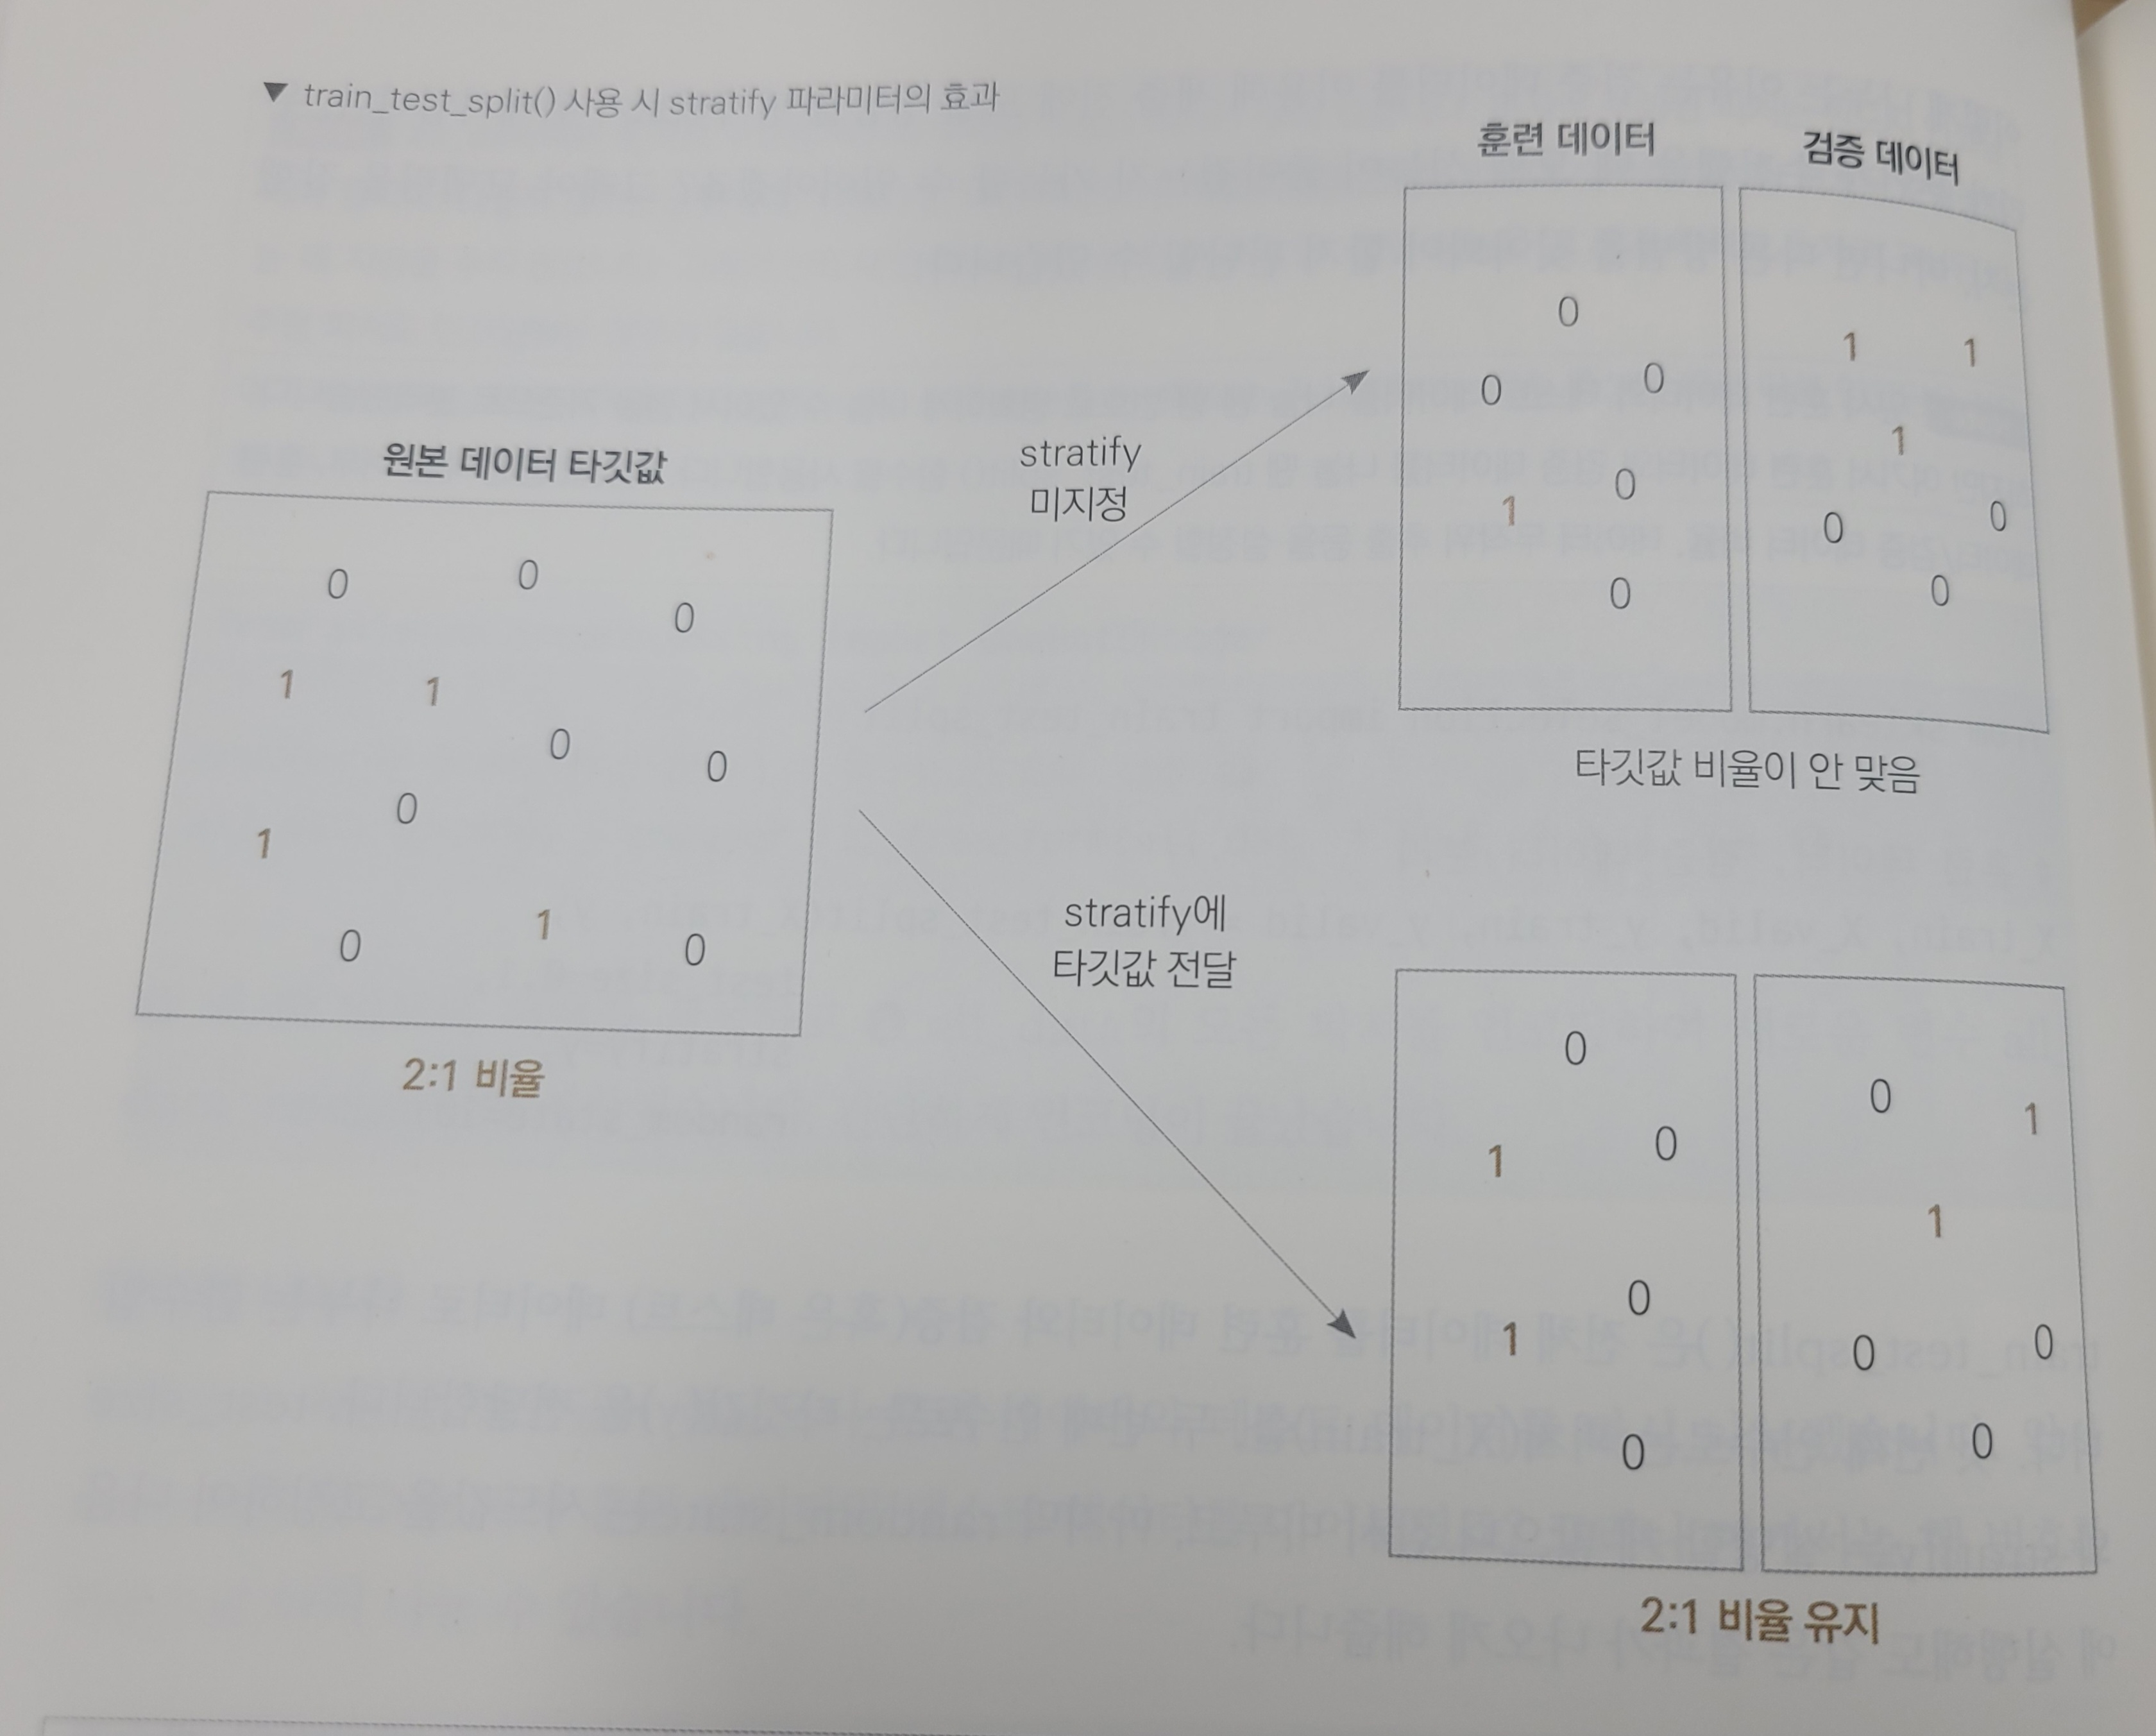

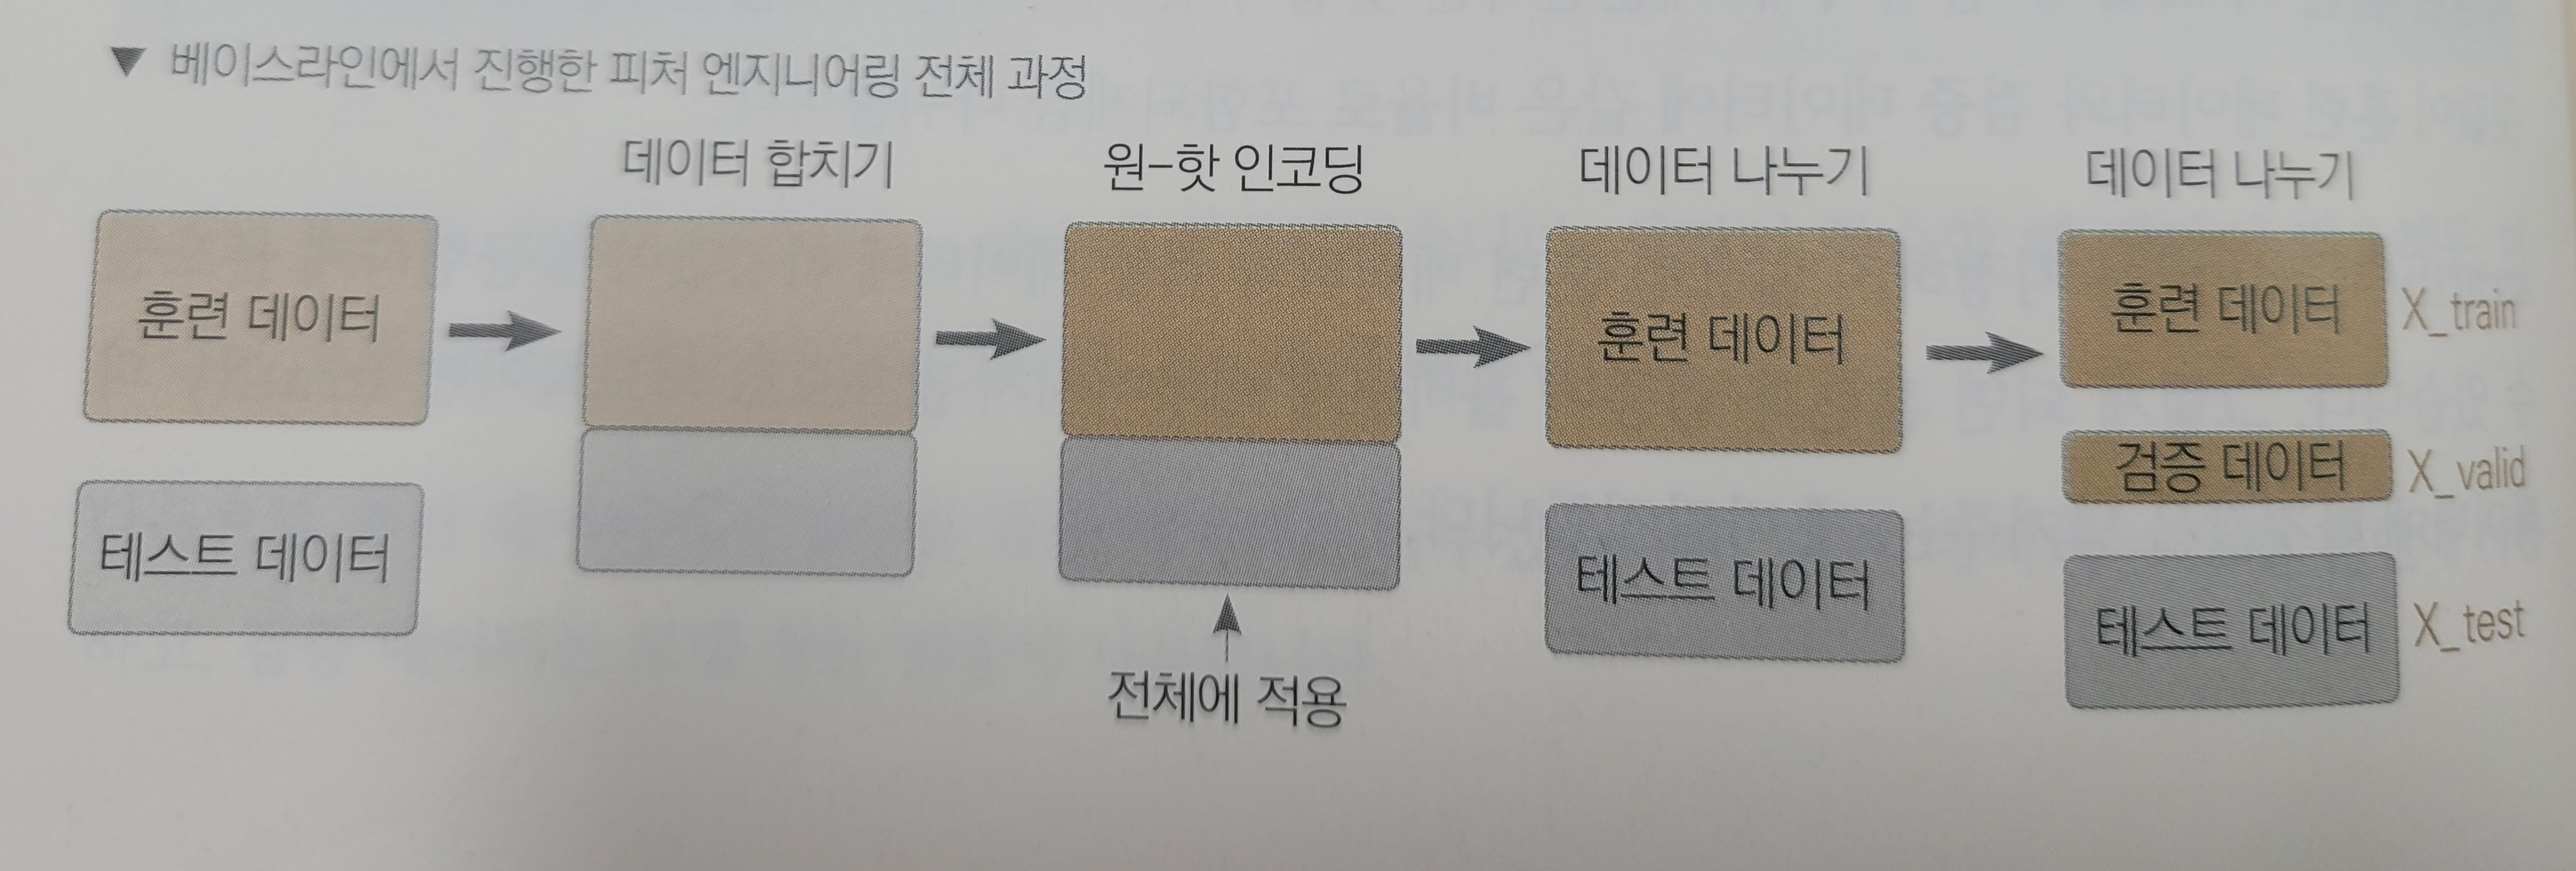

# 모델훈련

In [7]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter = 1000, random_state = 42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [8]:
y_valid_preds = logistic_model.predict_proba(X_valid)[:,1]

타깃값이 1일 확률이 저장

예측값과 실제 타깃값으로 ROC-AUC를 구하려고 함

In [9]:
from sklearn.metrics import roc_auc_score 

# valid set ROC-AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'valid data ROC-AUC score : {roc_auc:.4f}')

valid data ROC-AUC score : 0.7965


# 예측 및 결과 제출

In [10]:
y_preds=logistic_model.predict_proba(X_test)[:,1]

In [11]:
submission['target']=y_preds
submission.to_csv("logistic.csv")

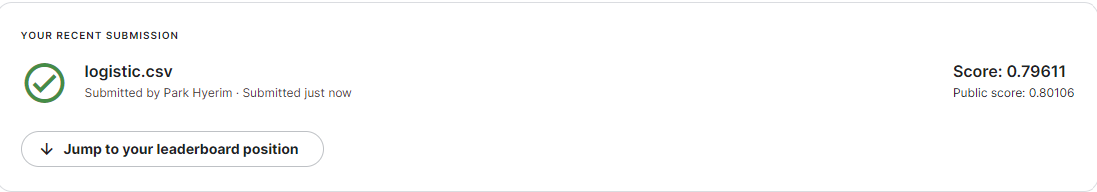

# 성능개선1

## 이진 피처 인코딩

bin_0 ~ bin_2는 이미 0과 1로만 구성되어있기 때문에 따로 인코딩하지 않아도 됨

In [12]:
all_data['bin_3'] = all_data['bin_3'].map({'F' : 0, 'T' : 1})
all_data['bin_4'] = all_data['bin_4'].map({'N' : 0, 'Y' : 1})

## 순서형 피처 인코딩

In [13]:
all_data['ord_1'] = all_data['ord_1'].map({'Novice' : 0, 'Contributor' : 1,
                                           'Expert' : 2, 'Master' : 3, 'Grandmaster' : 4})

all_data['ord_2'] = all_data['ord_2'].map({'Freezing' : 0, 'Cold' : 1,
                                           'Warm' : 2, 'Hot' : 3, 
                                           'Boiling Hot' : 4, 'Lava Hot' : 5})

ord_3~ord_5는 사이킷런의 `OrdinalEncoder` 이용

In [14]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']
ord_encoder = OrdinalEncoder()

all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

# 피처별 인코딩 순서 출력 
for feature, categories in zip(ord_345, ord_encoder.categories_) : 
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

## 명목형 피처 인코딩

순서를 무시해도 되기 때문에 원-핫 인코딩 적용

In [15]:
nom_features = ['nom_' + str(i) for i in range(10)]

**정상 실행되지 않는 코드**  
열 개수가 늘어나서 곧바로 안코딩할 수 없기 때문  


from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
all_data[nom_features] = onehot_encoder.fit_transform(all_data[nom_features])

**제대로 된 코드**

In [16]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

In [17]:
encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

In [18]:
all_data.drop(nom_features, axis = 1, inplace = True)

기존의 명목형 변수는 삭제

## 날짜 피처 인코딩

In [19]:
date_features = ['day', 'month'] 

encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])

all_data.drop(date_features, axis = 1, inplace = True)

encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

## 순서형 피처 스케일링

이진, 명목형, 날짜 피처는 모두 0과 1로 인코딩했지만 순서형 변수는 여러 값을 갖기 떄문에 0과 1사이의 범위의 값을 갖도록 스케일링을 수행해줘야 함

- min-max 정규화를 적용

In [20]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)] 

minmax_scaler = MinMaxScaler()

all_data[ord_features] = minmax_scaler.fit_transform(all_data[ord_features])

## 인코딩 및 스케일링된 피처 합치기

all_data는 DataFrame이고 encoded_nom_matrix와 encoded_date_matrix는 CSR 형식의 파일이기 때문에 형식을 맞춰주어야 함

In [21]:
from scipy import sparse

In [22]:
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                               encoded_nom_matrix,
                               encoded_date_matrix], format = 'csr')

In [23]:
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

In [24]:
X_train = all_data_sprs[:len(train)]
X_test = all_data_sprs[len(train):]

y = train['target']

In [25]:
from sklearn.model_selection import train_test_split 

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, 
                                                      test_size = 0.1,
                                                      stratify = y,
                                                      random_state = 10)

##  하이퍼 파라미터 최적화

In [26]:
%%time 

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 

# 모델 생성
logistic_model = LogisticRegression()

# 하이퍼파라미터 목록
lr_params = {'C' : [0.1, 0.125, 0.15], 
             'max_iter' : [500, 600, 700], 
             'solver' : ['liblinear'], 
             'random_state' : [42],
             'n_jobs' : [-1]}

# 그리드서치 객체 생성 
gridsearch_logistic_model = GridSearchCV(estimator = logistic_model, 
                                         param_grid = lr_params, 
                                         scoring = 'roc_auc', 
                                         cv = 5, 
                                         verbose = 1)

# 그리드서치 수행 
gridsearch_logistic_model.fit(X_train, y_train)

print(f'최적 하이퍼 파라미터 : {gridsearch_logistic_model.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


최적 하이퍼 파라미터 : {'C': 0.125, 'max_iter': 500, 'n_jobs': -1, 'random_state': 42, 'solver': 'liblinear'}
Wall time: 3min 29s


# 모델 성능 검증

In [27]:
y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:, 1]

from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'valid data ROC-AUC : {roc_auc:.4f}')

valid data ROC-AUC : 0.8045


# 결과 파일 제출

In [31]:
y_preds_1 = logistic_model.predict_proba(X_test)[:, 1]

In [32]:
submission['target'] = y_preds_1
submission.to_csv('submission_1.csv')

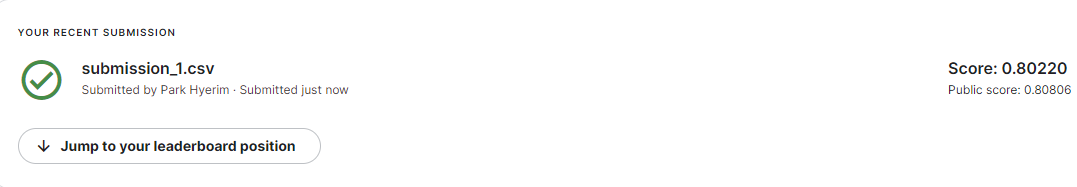

# 성능 개선2

valid set이 전체 훈련 데이터의 10%를 차지  
이를 검증용으로만 사용하면 그만큼의 데이터를 낭비하는 것이기 때문에 모델링 절차를 그대로 유지한 채로 훈련 데이터 전체를 사용해서 모델을 훈련

In [44]:
X_train = all_data_sprs[:len(train)]

In [45]:
logistic_model = gridsearch_logistic_model.best_estimator_
logistic_model.fit(X_train, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


LogisticRegression(C=0.125, max_iter=500, n_jobs=-1, random_state=42,
                   solver='liblinear')

In [46]:
y_preds_2 = logistic_model.predict_proba(X_test)[:, 1]

In [47]:
submission['target'] = y_preds_2
submission.to_csv('submission_2.csv')

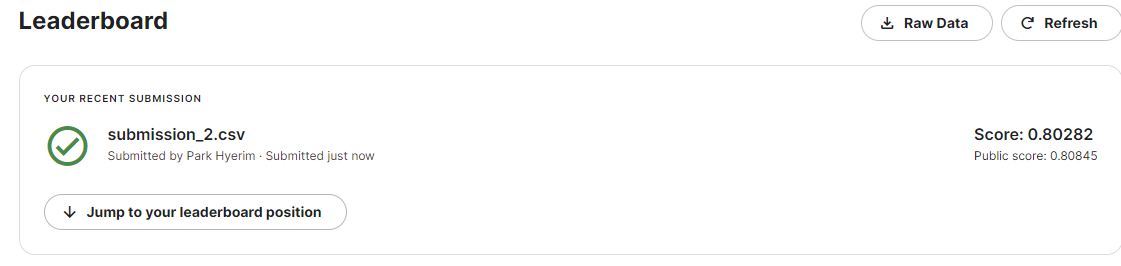